# CPU Cycles and Degree of Data Selectivity

This experiment evaluates the cost of total CPU cycles during transferring different percentages of the whole **dataset (50GB)** from multiple servers to a client using a simple data filtering function. The transmission size range from 10% to 90% of the dataset, which is generated/filled with only digits under uniform distribution, to represent different degrees of data selectivity. We hold the following assumption in this experiment as follows,

- Both the servers and client have the same CPU model.
- Producing worksets of high data selectivity (smaller transmission size) consumes more CPU cycles than worksets of low data selectivity (larger transmission size).

## Data Filtering Function

The data filtering function we evaluated in this experiment is a lambda function
```python
lambda v: v not in list(b'0123456789')[:LEN]
```
where `LEN` between 1 and 9 is for controlling the degree of data selectivity.

For each byte in the dataset, we use the above function to check if the current byte should be transmitted. Specifically, a bigger `LEN` results in high data selectivity while smaller `LEN` permits more bytes in the dataset to be transmitted meaning low data selectivity in other words. To verify high data selectivity should cost more CPU cycles than low data selectivity with this function, we have this proof of concept to show the differences of time and cycles consumptions of these two cases:


```bash
docker run --rm -ti --cap-add SYS_ADMIN ljishen/perf:4.9-python3 stat \
    python3 -m timeit -s "expr = lambda v: v not in list(b'0123456789')[:9]" "expr(48)"
1000000 loops, best of 3: 0.53 usec per loop

 Performance counter stats for 'python3 -m timeit -s expr = lambda x: x not in list(b'0123456789')[:9] expr(48)':

       2498.401472      task-clock (msec)         #    1.000 CPUs utilized          
                 3      context-switches          #    0.001 K/sec                  
                 0      cpu-migrations            #    0.000 K/sec                  
              3627      page-faults               #    0.001 M/sec                  
        6914129443      cycles                    #    2.767 GHz                    
       16216707149      instructions              #    2.35  insn per cycle         
        3711921245      branches                  # 1485.718 M/sec                  
           5161883      branch-misses             #    0.14% of all branches        

       2.499271785 seconds time elapsed
```
---

```bash       
docker run --rm -ti --cap-add SYS_ADMIN ljishen/perf:4.9-python3 stat \
    python3 -m timeit -s "expr = lambda v: v not in list(b'0123456789')[:1]" "expr(48)"
1000000 loops, best of 3: 0.46 usec per loop

 Performance counter stats for 'python3 -m timeit -s expr = lambda x: x not in list(b'0123456789')[:1] expr(48)':

       2211.099283      task-clock (msec)         #    0.996 CPUs utilized          
                 6      context-switches          #    0.003 K/sec                  
                 0      cpu-migrations            #    0.000 K/sec                  
              3629      page-faults               #    0.002 M/sec                  
        6741664677      cycles                    #    3.049 GHz                    
       15562575721      instructions              #    2.31  insn per cycle         
        3547408130      branches                  # 1604.364 M/sec                  
           8796172      branch-misses             #    0.25% of all branches        

       2.219600636 seconds time elapsed
```

To summarize,

|Selectivity | Function                                    | CPU Cycles (1000000 loop)  | Time (usec per loop)  |
|:-----------|:--------------------------------------------|:---------------------------|:----------------------|
|High        |lambda v: v not in list(b'0123456789')[:9]  | 6914129443                 | 0.53                  |
|Low         |lambda v: v not in list(b'0123456789')[:1]  | 6741664677                 | 0.46                  |

## Experiment Setup

### Machine Configuration

1 client node and 8 server nodes are all the same machine type from cloudlab:

**c220g2**    Haswell, 20 core, 3 disks

---
```
CPU       Two Intel E5-2660 v3 10-core CPUs at 2.60 GHz (Haswell EP)
RAM       160GB ECC Memory (10x 16 GB DDR4 2133 MHz dual rank RDIMMs)
Disk      One Intel DC S3500 480 GB 6G SATA SSDs
Disk      Two 1.2 TB 10K RPM 6G SAS SFF HDDs
NIC       Dual-port Intel X520 10Gb NIC (PCIe v3.0, 8 lanes
NIC       Onboard Intel i350 1Gb
```
---

### Architecture

![experiment_setup](../images/experiment_setup.png)

In [1]:
from IPython.display import display, Markdown

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
_AVG = 'avg'
_STD = 'std'

def gen_df(json_file):
    FILE_PATH = '../backups/pyben-nio/' + json_file
    
    with open(FILE_PATH, 'r') as fobj:
        df = pd.read_json(fobj)

    for size in df.columns:
        size_df = df[size]

        for nservs in size_df.index:
            nservs_df = size_df[nservs]

            client_bitrates = nservs_df['bitrate']['client']
            nservs_df['bitrate']['client'] = \
                {_AVG: np.mean(client_bitrates), _STD: np.std(client_bitrates, ddof=1)}

            client_cycles = nservs_df['cycles']['client']
            nservs_df['cycles']['client'] = \
                {_AVG: np.mean(client_cycles), _STD: np.std(client_cycles, ddof=1)}

            servers_bitrates = []
            servers_cycles = []
            for serv_idx in range(nservs):
                bitrates = [arr[serv_idx] for arr in nservs_df['bitrate']['servers']]
                servers_bitrates.append(
                    {_AVG: np.mean(bitrates), _STD: np.std(bitrates, ddof=1)})

                cycles = [arr[serv_idx] for arr in nservs_df['cycles']['servers']]
                servers_cycles.append(
                    {_AVG: np.mean(cycles), _STD: np.std(cycles, ddof=1)})

            nservs_df['bitrate']['servers'] = servers_bitrates
            nservs_df['cycles']['servers'] = servers_cycles
            
    return df

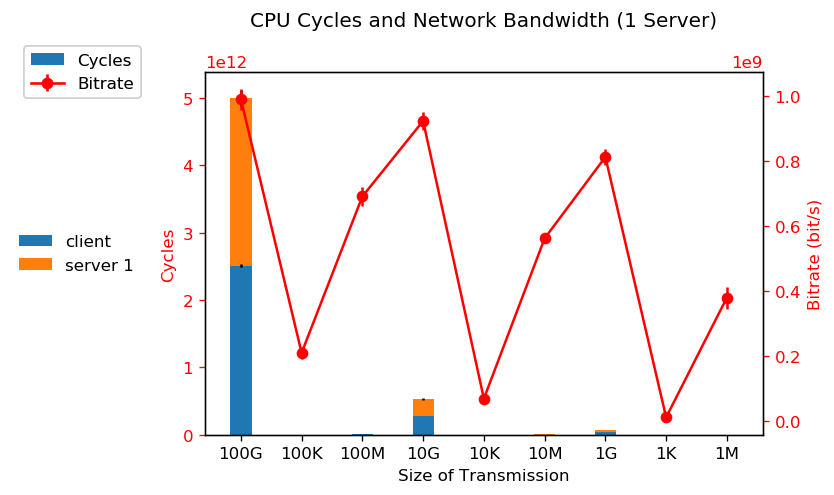

---

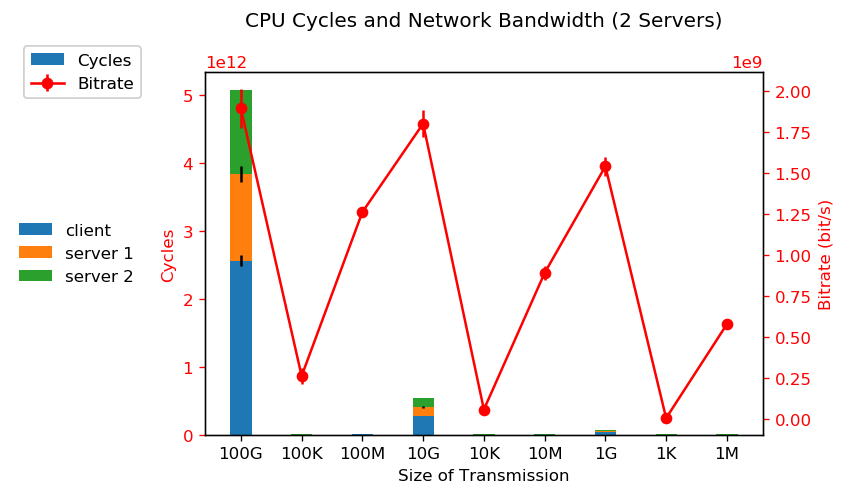

---

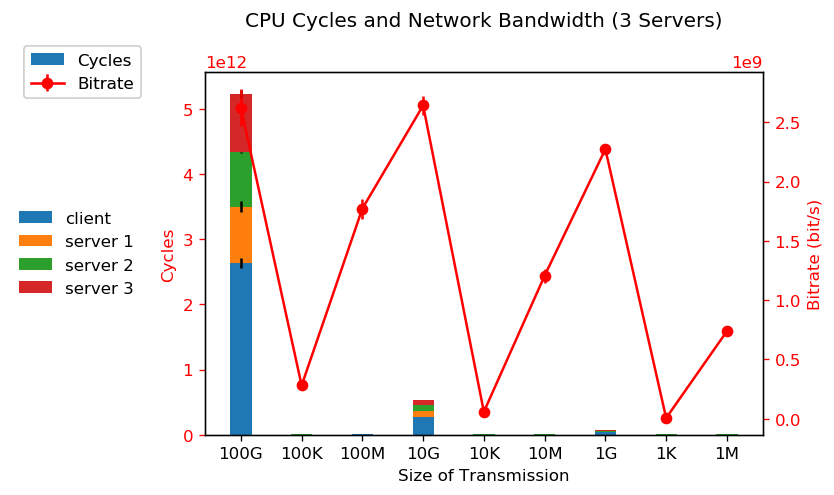

---

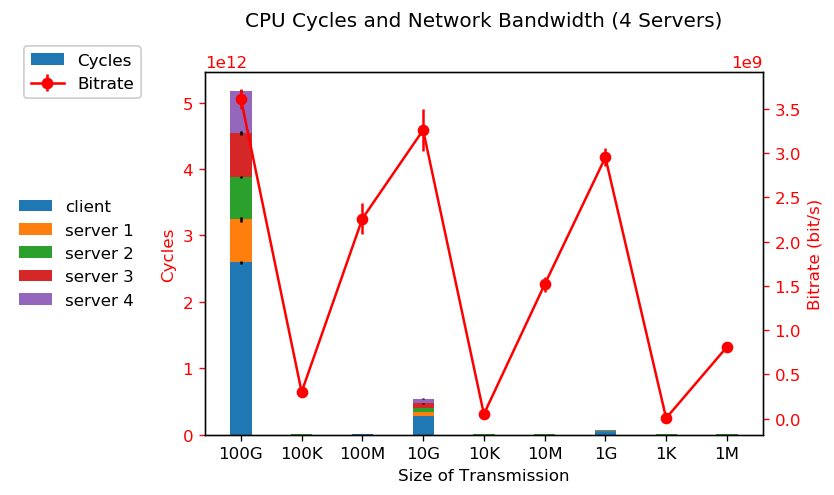

---

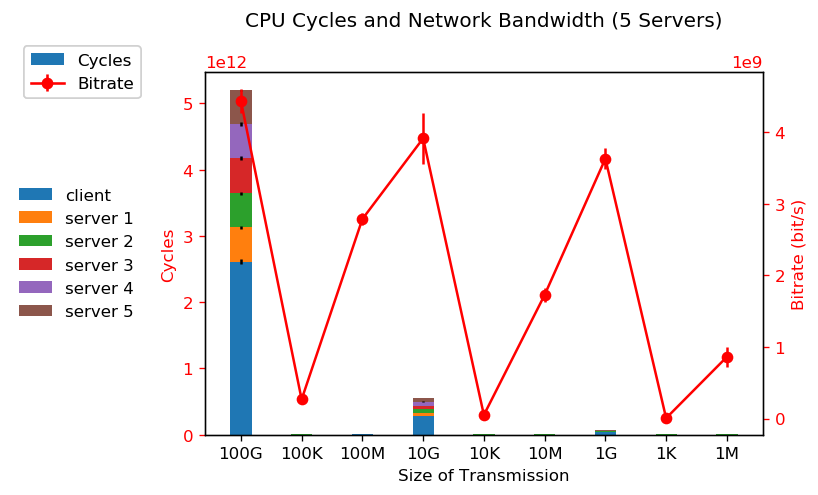

---

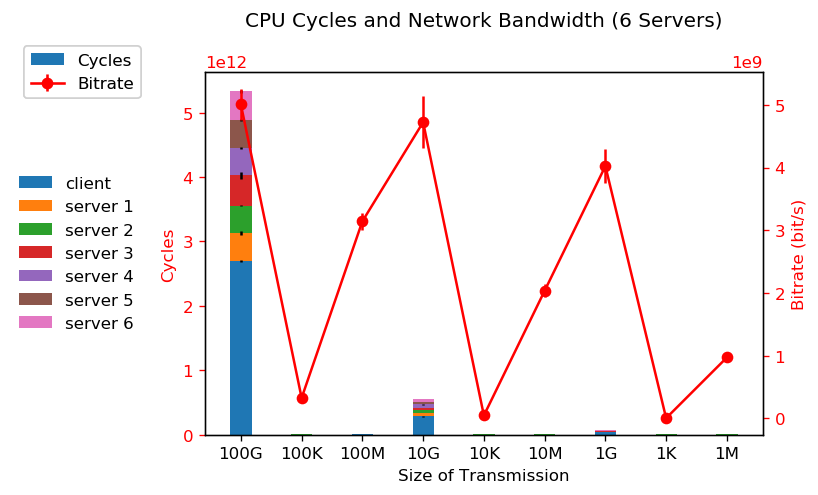

---

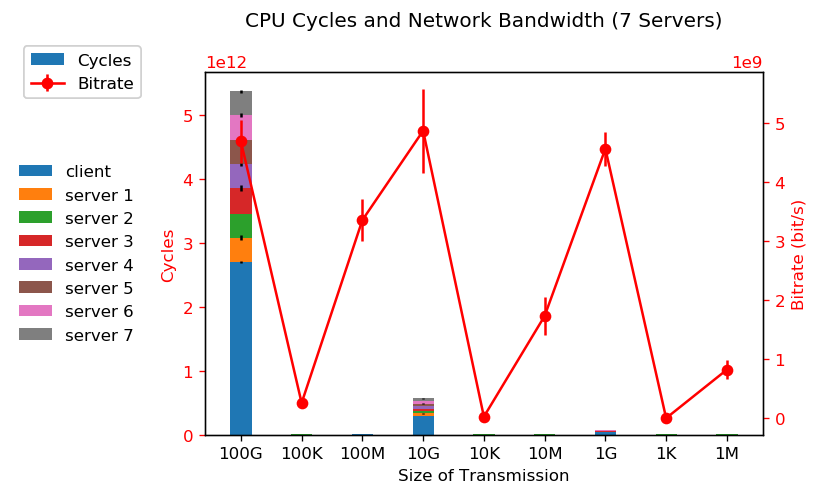

---

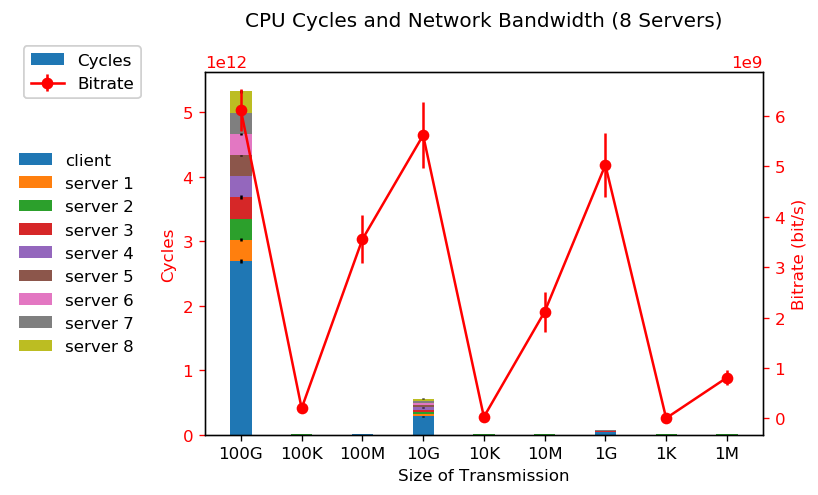

---

In [3]:
df = gen_df('output_servers_linspace_2_8servs/result.json')
N = len(df.columns)
ind = np.arange(N)
WIDTH = 0.35
YAX_CLR = 'r'

for num_servs in range(1, len(df.index) + 1):
    fig, ax1 = plt.subplots()
    
    # Change the size of figure
    # See https://stackoverflow.com/a/4306340
    fig.set_dpi(120)
    
    # Draw bins for Cycles
    cycle_bars = []
    
    ## Plot client cycles
    client_cycle_avgs = \
        [df[size][num_servs]['cycles']['client']['avg'] for size in df.columns]
    client_cycle_stds = \
        [df[size][num_servs]['cycles']['client']['std'] for size in df.columns]
    
    last_bottom = client_cycle_avgs
    cycle_bars.append(
        ax1.bar(ind,
                client_cycle_avgs,
                WIDTH,
                yerr=client_cycle_stds))
    
    ## Plot servers cycles
    for serv_idx in range(num_servs):
        server_cycle_avgs = \
            [df[size][num_servs]['cycles']['servers'][serv_idx]['avg'] for size in df.columns]
        server_cycle_stds = \
            [df[size][num_servs]['cycles']['servers'][serv_idx]['std'] for size in df.columns]
            
        cycle_bars.append(
            ax1.bar(ind,
                    server_cycle_avgs,
                    WIDTH,
                    bottom=last_bottom,
                    yerr=server_cycle_stds))
        last_bottom = np.sum([last_bottom, server_cycle_avgs], axis=0)
    
    ax1.set_ylabel('Cycles', color=YAX_CLR)
    ax1.tick_params('y', colors=YAX_CLR)
    ax1.set_xlabel('% of the Dataset')
    
    plt.legend(
        cycle_bars,
        ['client'] + ['server ' + str(idx) for idx in df.index],
        loc=5,
        bbox_to_anchor=(-0.1, 0.5),
        frameon=False)
    
    
    # Draw bitrate for client
    ax2 = ax1.twinx()
    
    client_bitrate_avgs = \
        [df[size][num_servs]['bitrate']['client']['avg'] for size in df.columns]
    client_bitrate_stds = \
        [df[size][num_servs]['bitrate']['client']['std'] for size in df.columns]
    
    bitrate_bar = ax2.errorbar(
        ind,
        client_bitrate_avgs,
        yerr=client_bitrate_stds,
        color=YAX_CLR,
        fmt='-o')
    
    ax2.set_ylabel('Bitrate (bit/s)', color=YAX_CLR)
    ax2.tick_params('y', colors=YAX_CLR)

    plt.gca().add_artist(plt.legend(
        [cycle_bars[0], bitrate_bar],
        ['Cycles', 'Bitrate'],
        loc=5,
        bbox_to_anchor=(-0.1, 1)))
    
    plt.xticks(ind, df.columns)
    plt.title(
        'CPU Cycles and Network Bandwidth (' + str(num_servs) + \
        ' Server' + ('s' if num_servs > 1 else '') + ')', y=1.1)

    plt.show()
    display(Markdown('---'))